In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
N = 10 # 城市数量
city = [
    (0.4, 0.4439), 
    (0.2439, 0.1463),
    (0.1707, 0.2293),
    (0.2293, 0.761),
    (0.5171, 0.9414),
    (0.8732, 0.6536),
    (0.6878, 0.5219),
    (0.8488, 0.3609),
    (0.6683, 0.2536),
    (0.6195, 0.2634)
] # 城市坐标
D = np.zeros([N, N]) # 距离矩阵
for i in range(N):
    for j in range(N):
        D[i][j] = np.sqrt((city[i][0]-city[j][0])**2+(city[i][1]-city[j][1])**2)

In [4]:
# 能量函数的超参数
a = 500
b = 500
c = 1000
d = 500
alpha = 0.0001

In [5]:
def hopfield():
    u0 = 0.02
    ifend = 0
    udao = np.zeros([N, N])
    ctr = 0 # 迭代次数
    while ifend == 0:
        ctr += 1
        # 初始化
        v = np.random.rand(N, N)
        u = np.ones([N, N])*(-u0*np.log(N-1)/2)
        u += u*0.91
        for _ in range(1000):
            for vx in range(N):
                for vi in range(N):
                    j1, j2, j3, j4 = 0, 0, 0, 0
                    # 求和1
                    for j in range(N):
                        if j != vi:
                            j1 += v[vx, j]
                    j1 *= -a
                    # 求和2
                    for y in range(N):
                        if y != vx:
                            j2 += v[y, vi]
                    j2 *= -b
                    # 求和3
                    j3 = np.sum(v)
                    j3 = -c*(j3-N)
                    # 求和4
                    for y in range(N):
                        if y != vx:
                            if vi == 0:
                                j4 += D[vx, y]*(v[y, vi+1]+v[y, N-1])
                            elif vi == N-1:
                                j4 += D[vx, y]*(v[y, vi-1]+v[y, 0])
                            else:
                                j4 += D[vx, y]*(v[y, vi+1]+v[y, vi-1])
                    j4 *= -d
                    udao[vx, vi] = -u[vx, vi] + j1 + j2 + j3 + j4
            # 更新u
            u += alpha*udao
            # 计算v
            v = (1+np.tanh(u/u0))/2
            # 使用0.7的阈值考察0与1
            for vx in range(N):
                for vi in range(N):
                    if(v[vx, vi] < 0.7):
                        v[vx, vi] = 0
                    if(v[vx, vi] >= 0.7):
                        v[vx, vi] = 1
        # 解的合法性测试
        t1, t2, t3 = 0, 0, 0
        for vx in range(N):
            for vi in range(N):
                t1 += v[vx, vi]
        for x in range(N):
            for i in range(N-1):
                for j in range(i+1, N):
                    t2 += np.multiply(v[x, i], v[x, j])
        for i in range(N):
            for x in range(N-1):
                for y in range(x+1, N):
                    t3 += np.multiply(v[x, i], v[y, i])
        if t1 == N and t2 == 0 and t3 == 0:
            ifend = 1
        else:
            ifend = 0
    return v, ctr

def total_distance(v):
    # 计算旅行序列的总距离
    cityx = np.zeros([N+1])
    cityy = np.zeros([N+1])
    for j in range(N):
        for i in range(N):
            if v[i,j] == 1:
                cityx[j] = city[i][0]
                cityy[j] = city[i][1]

    cityx[N] = cityx[0]
    cityy[N] = cityy[0]
    res = 0
    for i in range(N-1):
        res += np.sqrt((cityx[i]-cityx[i+1])**2+(cityy[i]-cityy[i+1])**2)
    res += np.sqrt((cityx[N-1]-cityx[0])**2+(cityy[N-1]-cityy[0])**2)
    return res, cityx, cityy

In [6]:
# 构造实际解的矩阵
v_ideal = np.zeros([N,N])
seq = [0, 3, 4, 5, 6, 7, 8, 9, 1, 2]
j = 0
for el in seq:
    v_ideal[el, j] = 1
    j += 1
print(v_ideal)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [8]:
v = np.zeros([N,N])
des_td = 2.6907
ct = 0
optimal_list = []
while True:
    ct += 1
    v, steps = hopfield()
    distance, _, _ = total_distance(v)
    if np.array_equiv(v, v_ideal):
        print("在{}次迭代中求得该TSP问题的最优解".format(ct))
        print("距离为：", distance)
        optimal_list.append(v)
        break
    elif distance <= des_td:
        print("在{}次迭代中求得最优解".format(ct))
        optimal_list.append(v)
    else:
        print("未求得最优解，执行步骤数为{}，总距离为{}".format(steps, distance))

未求得最优解，执行步骤数为2，总距离为2.7693317173730323
未求得最优解，执行步骤数为7，总距离为2.990124161239297
未求得最优解，执行步骤数为2，总距离为3.2638594701979904
未求得最优解，执行步骤数为13，总距离为3.3117269798364513
未求得最优解，执行步骤数为1，总距离为3.252342723298946
未求得最优解，执行步骤数为4，总距离为2.7693317173730323
未求得最优解，执行步骤数为1，总距离为2.8392822261223336
未求得最优解，执行步骤数为2，总距离为3.170283426841171
未求得最优解，执行步骤数为1，总距离为2.8392822261223336
未求得最优解，执行步骤数为19，总距离为3.062043714668075
未求得最优解，执行步骤数为1，总距离为3.5071372966651646
在12次迭代中求得最优解
未求得最优解，执行步骤数为11，总距离为2.7517375757634683
未求得最优解，执行步骤数为1，总距离为3.0691311427903414
未求得最优解，执行步骤数为13，总距离为4.081190236820926
未求得最优解，执行步骤数为2，总距离为3.0365751666168226
未求得最优解，执行步骤数为4，总距离为2.9035375887464467
在18次迭代中求得该TSP问题的最优解
距离为： 2.6906706370094136


In [23]:
def get_route(v):
    # 生成旅行城市序列
    route = ""
    for j in range(v.shape[1]):
        route += str(np.argmax(v[:, j])) + '->'
    return route + str(np.argmax(v[:, 0]))
print(get_route(v_ideal))

In [25]:
def annot_plot(N, city):
    labels = np.arange(10)
    cityx, cityy = [], []
    for i in range(N):
        cityx.append(city[i][0])
        cityy.append(city[i][1])
    for label, x, y in zip(labels, cityx, cityy):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )

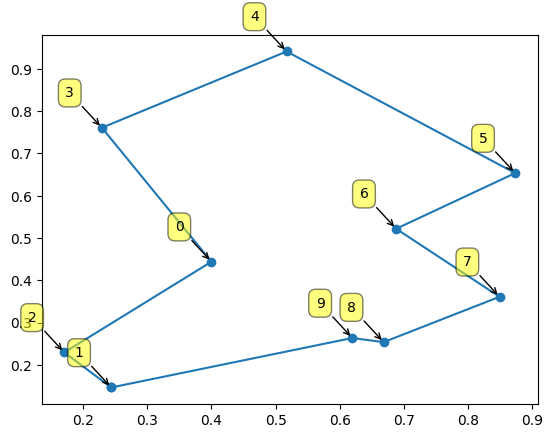

In [28]:
v = optimal_list[0]
td, X, Y = total_distance(v)
plt.plot(X, Y,'o-')
annot_plot(N, city)